In [2]:
!pip install transformers datasets peft

In [3]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("facebook/empathetic_dialogues")

# Function to clean the data
def preprocess(example):
    # Replace "_comma_" with ", " in the utterance column
    if example["utterance"] is not None:  # Check for null values
        example["utterance"] = example["utterance"].replace("_comma_", ",")
        example["prompt"] = example["prompt"].replace("_comma_", ",")
    return example

# Apply preprocessing
dataset = dataset.map(preprocess)

# Function to remove null values
def remove_null(example):
    return example["utterance"] is not None  # Keep only non-null utterances

# Apply filtering to remove null values
dataset = dataset.filter(remove_null)

# Display an example after preprocessing
print(dataset["train"][0:8])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.15k [00:00<?, ?B/s]

empathetic_dialogues.py:   0%|          | 0.00/4.51k [00:00<?, ?B/s]

The repository for facebook/empathetic_dialogues contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/facebook/empathetic_dialogues.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/76673 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/12030 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10943 [00:00<?, ? examples/s]

Map:   0%|          | 0/76673 [00:00<?, ? examples/s]

Map:   0%|          | 0/12030 [00:00<?, ? examples/s]

Map:   0%|          | 0/10943 [00:00<?, ? examples/s]

Filter:   0%|          | 0/76673 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12030 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10943 [00:00<?, ? examples/s]

{'conv_id': ['hit:0_conv:1', 'hit:0_conv:1', 'hit:0_conv:1', 'hit:0_conv:1', 'hit:0_conv:1', 'hit:0_conv:1', 'hit:1_conv:2', 'hit:1_conv:2'], 'utterance_idx': [1, 2, 3, 4, 5, 6, 1, 2], 'context': ['sentimental', 'sentimental', 'sentimental', 'sentimental', 'sentimental', 'sentimental', 'afraid', 'afraid'], 'prompt': ['I remember going to the fireworks with my best friend. There was a lot of people, but it only felt like us in the world.', 'I remember going to the fireworks with my best friend. There was a lot of people, but it only felt like us in the world.', 'I remember going to the fireworks with my best friend. There was a lot of people, but it only felt like us in the world.', 'I remember going to the fireworks with my best friend. There was a lot of people, but it only felt like us in the world.', 'I remember going to the fireworks with my best friend. There was a lot of people, but it only felt like us in the world.', 'I remember going to the fireworks with my best friend. There

In [5]:
from datasets import load_dataset
import pandas as pd

# Load the dataset
#dataset = load_dataset("daily_dialog")

# Convert train and test splits to Pandas DataFrames
df_train = dataset["train"].to_pandas()
df_test = dataset["test"].to_pandas()

# Display the first few rows
print(df_train.head())
print(df_train.columns)  # Check column names

        conv_id  utterance_idx      context  \
0  hit:0_conv:1              1  sentimental   
1  hit:0_conv:1              2  sentimental   
2  hit:0_conv:1              3  sentimental   
3  hit:0_conv:1              4  sentimental   
4  hit:0_conv:1              5  sentimental   

                                              prompt  speaker_idx  \
0  I remember going to the fireworks with my best...            1   
1  I remember going to the fireworks with my best...            0   
2  I remember going to the fireworks with my best...            1   
3  I remember going to the fireworks with my best...            0   
4  I remember going to the fireworks with my best...            1   

                                           utterance     selfeval tags  
0  I remember going to see the fireworks with my ...  5|5|5_2|2|5       
1  Was this a friend you were in love with, or ju...  5|5|5_2|2|5       
2                This was a best friend. I miss her.  5|5|5_2|2|5       
3         

In [6]:
# Keep only rows that DO NOT contain "_conv:" in the utterances column
df_train = df_train[~df_train['utterance'].str.contains('_conv:')]
df_test = df_test[~df_test['utterance'].str.contains('_conv:')]

In [7]:
# Check if any rows still have '_conv:'
df_train[df_train['utterance'].str.contains('_conv:')]
df_test[df_test['utterance'].str.contains('_conv:')]

,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags


In [ ]:
df_train.to_csv('check.csv', index=False)


In [ ]:
# Check if any still exist
df_train[df_train['utterance'].str.match(pattern)]


,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags


In [ ]:
from google.colab import files
files.download('check.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd

# Assuming your dataframe is named df
# Step 1: Drop the 'selfeval' and 'tags' columns
df_train = df_train.drop(columns=['selfeval', 'tags'])
df_test = df_test.drop(columns=['selfeval', 'tags'])

def group_conversations(df):
    """
    Groups conversation data by 'conv_id'.

    Args:
        df (pd.DataFrame): Original dataframe containing conv_id, prompt, context, utterance_idx, and utterance.

    Returns:
        pd.DataFrame: Grouped dataframe with combined utterances and representative prompt/context.
    """
    grouped_df = (
        df.groupby('conv_id')
        .apply(lambda x: pd.Series({
            'prompt': x['prompt'].iloc[0],  # Take the first prompt
            'context': x['context'].iloc[0],  # Take the first context
            'utterances': ' '.join(x.sort_values('utterance_idx')['utterance'].astype(str))  # Combine utterances
        }))
        .reset_index()
    )
    return grouped_df

grouped_df_train = group_conversations(df_train)
grouped_df_test = group_conversations(df_test)

print(grouped_df_train.head())
print(grouped_df_test.head())



<ipython-input-24-17cba304addc>:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


                conv_id                                             prompt  \
0          hit:0_conv:1  I remember going to the fireworks with my best...   
1  hit:10000_conv:20000  My girlfriend got me a toad today! I was so sh...   
2  hit:10000_conv:20001       I really like the new paint job on my house.   
3  hit:10001_conv:20002  I went to the skating rink all by myself today...   
4  hit:10002_conv:20004  I was walking on the road. I saw beggar and i ...   

       context                                         utterances  
0  sentimental  I remember going to see the fireworks with my ...  
1    surprised  My girlfriend got me a pet toad today! Do you ...  
2    impressed  I really like the new paint job on my house. T...  
3       lonely  I went to the skating rink all by myself today...  
4      ashamed  I was walking on the road. I saw a beggar and ...  
                conv_id                                             prompt  \
0          hit:0_conv:0  I felt guilty when I

<ipython-input-24-17cba304addc>:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


In [ ]:
label_counts_train = grouped_df_train["context"].value_counts()
label_counts_test = grouped_df_test["context"].value_counts()
print(label_counts_train)
print(grouped_df_train.shape)
print(label_counts_test)
print(grouped_df_test.shape)

context
surprised       924
excited         683
proud           636
angry           636
annoyed         613
sad             609
grateful        586
lonely          585
afraid          584
terrified       578
anxious         571
guilty          571
disgusted       569
confident       566
hopeful         564
impressed       561
anticipating    561
furious         553
joyful          552
disappointed    549
nostalgic       542
prepared        536
jealous         535
content         516
devastated      514
embarrassed     511
caring          474
sentimental     473
trusting        453
ashamed         445
apprehensive    418
faithful        325
Name: count, dtype: int64
(17793, 4)
context
surprised       127
proud            96
grateful         95
excited          91
sentimental      91
annoyed          91
sad              88
disgusted        86
angry            84
joyful           83
disappointed     81
embarrassed      81
jealous          81
impressed        81
caring           80
hopeful

In [ ]:
from transformers import pipeline
emotion_classifier = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    truncation=True,
    max_length=512,
    top_k=None    # updated from return_all_scores=True
)

def get_emotion_score(text):
    predictions = emotion_classifier(text)[0]
    max_prob = max([pred['score'] for pred in predictions])
    return round(max_prob * 10, 2)


#df_small['sentiment_score'] = df_small['utterances'].apply(get_emotion_score)
grouped_df_train['sentiment_score'] = grouped_df_train['utterances'].apply(get_emotion_score)
grouped_df_train.head()
#df_small.head()

#grouped_df_test['sentiment_score'] = grouped_df_test['utterances'].apply(get_emotion_score)
#grouped_df_test.head()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


,conv_id,prompt,context,utterances,sentiment_score
0,hit:0_conv:1,I remember going to the fireworks with my best...,sentimental,I remember going to see the fireworks with my ...,4.11
1,hit:10000_conv:20000,My girlfriend got me a toad today! I was so sh...,surprised,My girlfriend got me a pet toad today! Do you ...,9.61
2,hit:10000_conv:20001,I really like the new paint job on my house.,impressed,I really like the new paint job on my house. T...,9.82
3,hit:10001_conv:20002,I went to the skating rink all by myself today...,lonely,I went to the skating rink all by myself today...,8.29
4,hit:10002_conv:20004,I was walking on the road. I saw beggar and i ...,ashamed,I was walking on the road. I saw a beggar and ...,5.43


In [ ]:
grouped_df_train.to_csv('grouped_df_train_with_scores.csv', index=False)


In [ ]:
from google.colab import files
files.download('grouped_df_train_with_scores.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
grouped_df_train.to_excel('grouped_df_train_with_scores.xlsx', index=False)


In [ ]:
from google.colab import files
files.download('grouped_df_train_with_scores.xlsx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Example path - you can customize this path to a folder inside your Google Drive
!cp grouped_df_train_with_scores.csv /content/drive/MyDrive/research


In [ ]:
# Example path - you can customize this path to a folder inside your Google Drive
!cp grouped_df_train_with_scores.xlsx /content/drive/MyDrive/research

In [ ]:
grouped_df_test['sentiment_score'] = grouped_df_test['utterances'].apply(get_emotion_score)
grouped_df_test.head()

,conv_id,prompt,context,utterances,sentiment_score
0,hit:0_conv:0,I felt guilty when I was driving home one nigh...,guilty,Yeah about 10 years ago I had a horrifying exp...,8.91
1,hit:10025_conv:20050,I was in for a treat the other day when my hus...,surprised,"I got something nice the other day, chocolates...",9.33
2,hit:10036_conv:20072,I have problems with the city and their consta...,trusting,I have problems with the city and their consta...,7.62
3,hit:10039_conv:20079,Everyday i wake up and see my girlfriends beau...,faithful,"I always do the same, it's not had when they a...",9.66
4,hit:10040_conv:20080,"I close on my new house Monday, I didn't think...",trusting,"I close on my new house Monday, I didn't think...",7.65


In [ ]:
grouped_df_test.to_csv('grouped_df_test_with_scores.csv', index=False)
grouped_df_test.to_excel('grouped_df_test_with_scores.xlsx', index=False)

In [ ]:
files.download('grouped_df_test_with_scores.csv')
files.download('grouped_df_test_with_scores.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Example path - you can customize this path to a folder inside your Google Drive
!cp grouped_df_test_with_scores.csv /content/drive/MyDrive/research

In [ ]:
# Example path - you can customize this path to a folder inside your Google Drive
!cp grouped_df_test_with_scores.xlsx /content/drive/MyDrive/research

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Replace with your actual file path
file_path_train = '/content/drive/MyDrive/research/grouped_df_train_with_scores.csv'
file_path_test = '/content/drive/MyDrive/research/grouped_df_test_with_scores.csv'

# Load the dataset
grouped_df_train = pd.read_csv(file_path_train)
grouped_df_test = pd.read_csv(file_path_test)

# Preview
grouped_df_train.head()
grouped_df_test.head()


Mounted at /content/drive


,conv_id,prompt,context,utterances,sentiment_score
0,hit:0_conv:0,I felt guilty when I was driving home one nigh...,guilty,Yeah about 10 years ago I had a horrifying exp...,8.91
1,hit:10025_conv:20050,I was in for a treat the other day when my hus...,surprised,"I got something nice the other day, chocolates...",9.33
2,hit:10036_conv:20072,I have problems with the city and their consta...,trusting,I have problems with the city and their consta...,7.62
3,hit:10039_conv:20079,Everyday i wake up and see my girlfriends beau...,faithful,"I always do the same, it's not had when they a...",9.66
4,hit:10040_conv:20080,"I close on my new house Monday, I didn't think...",trusting,"I close on my new house Monday, I didn't think...",7.65


In [ ]:
grouped_df_train.head()

,conv_id,prompt,context,utterances,sentiment_score
0,hit:0_conv:1,I remember going to the fireworks with my best...,sentimental,I remember going to see the fireworks with my ...,4.11
1,hit:10000_conv:20000,My girlfriend got me a toad today! I was so sh...,surprised,My girlfriend got me a pet toad today! Do you ...,9.61
2,hit:10000_conv:20001,I really like the new paint job on my house.,impressed,I really like the new paint job on my house. T...,9.82
3,hit:10001_conv:20002,I went to the skating rink all by myself today...,lonely,I went to the skating rink all by myself today...,8.29
4,hit:10002_conv:20004,I was walking on the road. I saw beggar and i ...,ashamed,I was walking on the road. I saw a beggar and ...,5.43


In [ ]:
import pandas as pd


# Define mappings for combining labels
context_mapping = {
    'terrified': 'terrified & afraid',
    'afraid': 'terrified & afraid',
    'furious': 'furious & angry',
    'angry': 'furious & angry',
    'ashamed': 'ashamed & guilty',
    'guilty': 'ashamed & guilty',
    'devastated': 'devastated & sad',
    'sad': 'devastated & sad',
    'sentimental': 'sentimental & nostalgic',
    'nostalgic': 'sentimental & nostalgic',
    'excited': 'excited & anticipating',
    'anticipating': 'excited & anticipating'
}

# Apply the mapping to the 'context' column
grouped_df_train['context'] = grouped_df_train['context'].replace(context_mapping)
grouped_df_test['context'] = grouped_df_test['context'].replace(context_mapping)

# Preview the updated DataFrame
print(grouped_df_train[['conv_id', 'context']])
print(grouped_df_test[['conv_id', 'context']])

# Optionally save the modified dataset
#df.to_csv('updated_dataset.csv', index=False)


                    conv_id                  context
0              hit:0_conv:1  sentimental & nostalgic
1      hit:10000_conv:20000                surprised
2      hit:10000_conv:20001                impressed
3      hit:10001_conv:20002                   lonely
4      hit:10002_conv:20004         ashamed & guilty
...                     ...                      ...
17788   hit:9999_conv:19999             apprehensive
17789     hit:999_conv:1998                confident
17790     hit:999_conv:1999         devastated & sad
17791       hit:99_conv:198         ashamed & guilty
17792         hit:9_conv:19              embarrassed

[17793 rows x 2 columns]
                   conv_id           context
0             hit:0_conv:0  ashamed & guilty
1     hit:10025_conv:20050         surprised
2     hit:10036_conv:20072          trusting
3     hit:10039_conv:20079          faithful
4     hit:10040_conv:20080          trusting
...                    ...               ...
2535   hit:9947_conv:19

In [ ]:
label_counts_train = grouped_df_train["context"].value_counts()
label_counts_test = grouped_df_test["context"].value_counts()
print(label_counts_train)
print(grouped_df_train.shape)
print(label_counts_test)
print(grouped_df_test.shape)

context
excited & anticipating     1244
furious & angry            1189
terrified & afraid         1162
devastated & sad           1123
ashamed & guilty           1016
sentimental & nostalgic    1015
surprised                   924
proud                       636
annoyed                     613
grateful                    586
lonely                      585
anxious                     571
disgusted                   569
confident                   566
hopeful                     564
impressed                   561
joyful                      552
disappointed                549
prepared                    536
jealous                     535
content                     516
embarrassed                 511
caring                      474
trusting                    453
apprehensive                418
faithful                    325
Name: count, dtype: int64
(17793, 5)
context
sentimental & nostalgic    168
excited & anticipating     163
devastated & sad           155
furious & angry       

In [ ]:
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import DistilBertTokenizer

# Load DistilBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
#tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer

# Example: Convert grouped_df_train (Pandas DataFrame) to HF Dataset
hf_dataset_train = Dataset.from_pandas(grouped_df_train)
hf_dataset_test = Dataset.from_pandas(grouped_df_test)

# Initialize your tokenizer (example with bert-base-uncased)
#tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# Create label mapping from training dataset
emotion_labels = {label: idx for idx, label in enumerate(set(hf_dataset_train["context"]))}

# View the mapping
print("Context-to-Label Mapping:\n", emotion_labels)

def encode_labels(example):
    example["labels"] = emotion_labels[example["context"]]
    return example

# Apply to training dataset
hf_dataset_train = hf_dataset_train.map(encode_labels)

# Apply to testing dataset using the SAME mapping
hf_dataset_test = hf_dataset_test.map(encode_labels)

# Check first few rows in train dataset
print(hf_dataset_train[:5])

# Check first few rows in test dataset
print(hf_dataset_test[:5])



Context-to-Label Mapping:
 {'joyful': 0, 'grateful': 1, 'sentimental & nostalgic': 2, 'prepared': 3, 'excited & anticipating': 4, 'trusting': 5, 'caring': 6, 'confident': 7, 'terrified & afraid': 8, 'devastated & sad': 9, 'annoyed': 10, 'anxious': 11, 'impressed': 12, 'surprised': 13, 'content': 14, 'ashamed & guilty': 15, 'faithful': 16, 'jealous': 17, 'apprehensive': 18, 'disappointed': 19, 'lonely': 20, 'hopeful': 21, 'disgusted': 22, 'embarrassed': 23, 'furious & angry': 24, 'proud': 25}


Map:   0%|          | 0/17793 [00:00<?, ? examples/s]

Map:   0%|          | 0/2540 [00:00<?, ? examples/s]

{'conv_id': ['hit:0_conv:1', 'hit:10000_conv:20000', 'hit:10000_conv:20001', 'hit:10001_conv:20002', 'hit:10002_conv:20004'], 'prompt': ['I remember going to the fireworks with my best friend. There was a lot of people, but it only felt like us in the world.', 'My girlfriend got me a toad today! I was so shocked and happy!', 'I really like the new paint job on my house.', 'I went to the skating rink all by myself today because my friends ditched me. I was so sad.', 'I was walking on the road. I saw beggar and i did not help him'], 'context': ['sentimental & nostalgic', 'surprised', 'impressed', 'lonely', 'ashamed & guilty'], 'utterances': ['I remember going to see the fireworks with my best friend. It was the first time we ever spent time alone together. Although there was a lot of people, we felt like the only people in the world. Was this a friend you were in love with, or just a best friend? This was a best friend. I miss her. Where has she gone? We no longer talk. Oh was this somet

In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import DistilBertTokenizer

# Example: Convert grouped_df_train (Pandas DataFrame) to HF Dataset
#hf_dataset_train = Dataset.from_pandas(grouped_df_train)
#tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Initialize your tokenizer (example with bert-base-uncased)
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Tokenize using HF Dataset .map()
tokenized_dataset_train = hf_dataset_train.map(
    lambda batch: tokenizer(
        batch["utterances"],
        padding='max_length',
        truncation=True,
        max_length = 96
    ),
    batched=True
)

tokenized_dataset_test = hf_dataset_test.map(
    lambda batch: tokenizer(
        batch["utterances"],
        padding='max_length',
        truncation=True,
        max_length = 96
    ),
    batched=True
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/17793 [00:00<?, ? examples/s]

Map:   0%|          | 0/2540 [00:00<?, ? examples/s]

In [ ]:
import torch
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_dataset_train,
    batch_size=16,
    shuffle=True,
    collate_fn=data_collator  # Dynamic padding applied here
)

test_dataloader = DataLoader(
    tokenized_dataset_test,
    batch_size=16,
    shuffle= False,
    collate_fn=data_collator  # Dynamic padding applied here
)

In [ ]:
tokenized_dataset_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels", "sentiment_score"])
print(tokenized_dataset_test[0:2])




{'conv_id': ['hit:0_conv:0', 'hit:10025_conv:20050'], 'prompt': ["I felt guilty when I was driving home one night and a person tried to fly into my lane, and didn't see me. I honked and they swerved back into their lane, slammed on their brakes, and hit the water cones.", 'I was in for a treat the other day when my husband got home with some chocolate. He likes to do things like that from time to time.'], 'context': ['ashamed & guilty', 'surprised'], 'utterances': ["Yeah about 10 years ago I had a horrifying experience. It was 100% their fault but they hit the water barrels and survived. They had no injuries but they almost ran me off the road. Did you suffer any injuries? No I wasn't hit. It turned out they were drunk. I felt guilty but realized it was his fault. Why did you feel guilty? People really shouldn't drive drunk. I don't know I was new to driving and hadn't experienced anything like that. I felt like my horn made him swerve into the water barrels.", 'I got something nice th

In [ ]:
tokenized_dataset_test.set_format(type="torch", columns=["input_ids", "attention_mask", "labels", "sentiment_score"])
print(tokenized_dataset_test[0:8])


{'sentiment_score': tensor([8.9100, 9.3300, 7.6200, 9.6600, 7.6500, 4.1900, 4.4300, 9.7700]), 'labels': tensor([15, 13,  5, 16,  5,  5, 15, 18]), 'input_ids': tensor([[  101,  3398,  2055,  2184,  2086,  3283,  1045,  2018,  1037,  7570,
         18752, 14116,  3325,  1012,  2009,  2001,  2531,  1003,  2037,  6346,
          2021,  2027,  2718,  1996,  2300, 13826,  1998,  5175,  1012,  2027,
          2018,  2053,  6441,  2021,  2027,  2471,  2743,  2033,  2125,  1996,
          2346,  1012,  2106,  2017,  9015,  2151,  6441,  1029,  2053,  1045,
          2347,  1005,  1056,  2718,  1012,  2009,  2357,  2041,  2027,  2020,
          7144,  1012,  1045,  2371,  5905,  2021,  3651,  2009,  2001,  2010,
          6346,  1012,  2339,  2106,  2017,  2514,  5905,  1029,  2111,  2428,
          5807,  1005,  1056,  3298,  7144,  1012,  1045,  2123,  1005,  1056,
          2113,  1045,  2001,  2047,  2000,   102],
        [  101,  1045,  2288,  2242,  3835,  1996,  2060,  2154,  1010,  7967,

In [ ]:
!pip install transformers datasets peft accelerate

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel


In [ ]:
num_labels = len(emotion_labels)

In [ ]:
class CustomBERTModel(nn.Module):
    def __init__(self, model_name, num_labels):
        super(CustomBERTModel, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)

        hidden_size = self.bert.config.hidden_size  # usually 768
        additional_feature_size = 1  # sentiment_score is a scalar

        self.dropout = nn.Dropout(0.3)

        self.classifier = nn.Linear(hidden_size + additional_feature_size, num_labels)

    def forward(self, input_ids, attention_mask, sentiment_score):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # Get [CLS] representation (first token)
        pooled_output = outputs.last_hidden_state[:, 0]  # shape: (batch_size, hidden_size)

        # Reshape sentiment_score to (batch_size, 1)
        sentiment_score = sentiment_score.unsqueeze(1)

        # Concatenate
        combined = torch.cat((pooled_output, sentiment_score), dim=1)

        # Dropout + classification
        combined = self.dropout(combined)
        logits = self.classifier(combined)

        return logits


In [ ]:
model_name = "distilbert-base-uncased"
model = CustomBERTModel(model_name, num_labels)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

# tokenized_dataset_train and tokenized_dataset_test are ready
# They should include input_ids, attention_mask, labels, sentiment_score

train_dataloader = DataLoader(tokenized_dataset_train, batch_size=16, shuffle=True)
test_dataloader = DataLoader(tokenized_dataset_test, batch_size=16, shuffle=False)


In [ ]:
criterion = nn.CrossEntropyLoss(reduction="none")
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [ ]:
model.train()

for epoch in range(1):  # Increase if needed
    total_loss = 0

    for batch_idx, batch in enumerate(train_dataloader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        sentiment_scores = batch["sentiment_score"].to(device)

        optimizer.zero_grad()

        # Forward pass with sentiment_score
        logits = model(input_ids=input_ids, attention_mask=attention_mask, sentiment_score=sentiment_scores)

        # Compute individual losses
        losses = criterion(logits, labels)

        # Normalize sentiment_scores if needed
        normalized_weights = sentiment_scores / sentiment_scores.max()

        # Apply weights
        weighted_losses = losses * normalized_weights
        loss = weighted_losses.mean()

        # Backprop and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch+1}], Batch [{batch_idx}], Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}] complete. Average Loss: {avg_loss:.4f}")


Epoch [1], Batch [0], Loss: 2.7004
Epoch [1], Batch [10], Loss: 2.4063
Epoch [1], Batch [20], Loss: 2.4545
Epoch [1], Batch [30], Loss: 2.3293
Epoch [1], Batch [40], Loss: 2.4146
Epoch [1], Batch [50], Loss: 2.3734
Epoch [1], Batch [60], Loss: 2.1725
Epoch [1], Batch [70], Loss: 2.2023
Epoch [1], Batch [80], Loss: 2.0078
Epoch [1], Batch [90], Loss: 1.5647
Epoch [1], Batch [100], Loss: 1.7156
Epoch [1], Batch [110], Loss: 1.2920
Epoch [1], Batch [120], Loss: 1.5042
Epoch [1], Batch [130], Loss: 1.1519
Epoch [1], Batch [140], Loss: 1.6172
Epoch [1], Batch [150], Loss: 1.5965
Epoch [1], Batch [160], Loss: 1.5838
Epoch [1], Batch [170], Loss: 1.8949
Epoch [1], Batch [180], Loss: 1.3682
Epoch [1], Batch [190], Loss: 1.1855
Epoch [1], Batch [200], Loss: 0.6815
Epoch [1], Batch [210], Loss: 1.6020
Epoch [1], Batch [220], Loss: 1.3846
Epoch [1], Batch [230], Loss: 0.9132
Epoch [1], Batch [240], Loss: 1.4591
Epoch [1], Batch [250], Loss: 1.1151
Epoch [1], Batch [260], Loss: 1.9948
Epoch [1], B

In [ ]:
!pip install scikit-learn

In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Switch to evaluation mode
model.eval()

# Track loss and predictions
total_loss = 0
all_predictions = []
all_labels = []

criterion = torch.nn.CrossEntropyLoss()  # Or use the same loss as during training if needed

# No gradient calculation (faster inference)
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        sentiment_scores = batch["sentiment_score"]
        labels = batch["labels"]

        # Forward pass through your custom model
        logits = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            sentiment_score=sentiment_scores  # make sure this matches your forward signature
        )

        # Compute loss
        loss = criterion(logits, labels)

        # Store total loss
        total_loss += loss.item()

        # Get predicted labels (highest probability class)
        predictions = torch.argmax(logits, dim=-1)

        # Store labels and predictions
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to tensors (optional since already numpy arrays)
all_predictions = torch.tensor(all_predictions)
all_labels = torch.tensor(all_labels)

# Calculate average validation loss
avg_loss = total_loss / len(test_dataloader)

# Compute evaluation metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average="weighted")  # Weighted for class imbalance
recall = recall_score(all_labels, all_predictions, average="weighted")
f1 = f1_score(all_labels, all_predictions, average="weighted")
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Display results
print(f"Validation Loss: {avg_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


Validation Loss: 1.5751
Accuracy: 0.5472
Precision: 0.5825
Recall: 0.5472
F1-score: 0.5458
Confusion Matrix:
[[ 13   5   0   1  16   0   1   3   1   1   0   0   8   7   4   0   0   0
    0   1   5   1   0   2   2  12]
 [  0  52   0   0   0   4   4   0   2   2   0   0   5   8   3   0   0   1
    0   0   2   1   1   1   0   9]
 [  1   4  96   0   7   2   0   0   2  21   1   0   9   4   2   1   0   0
    2   0   7   0   0   0   1   8]
 [  1   6   0  43   3   0   0  11   0   0   0   1   2   2   2   0   0   0
    0   1   0   1   0   2   1   1]
 [  7   0   1   5  96   2   1   2   2   0   1   4   4   2   3   0   0   0
    5   4   3   9   0   0   0  12]
 [  0   8   0   0   0  40   1   0   3   0   1   0   0   1   1   0   1   2
    2   0   0   1   0   1   1   1]
 [  3  10   0   0   0   4  46   0   0   4   0   0   1   1   0   1   0   0
    1   0   2   0   0   1   0   6]
 [  1   0   0   5   3   4   2  24   1   0   1   0   4   3   1   0   0   0
    3   2   0   9   0   1   0  11]
 [  0   0   0   1  

In [ ]:
!pip install scikit-learn

In [ ]:
!pip install seaborn

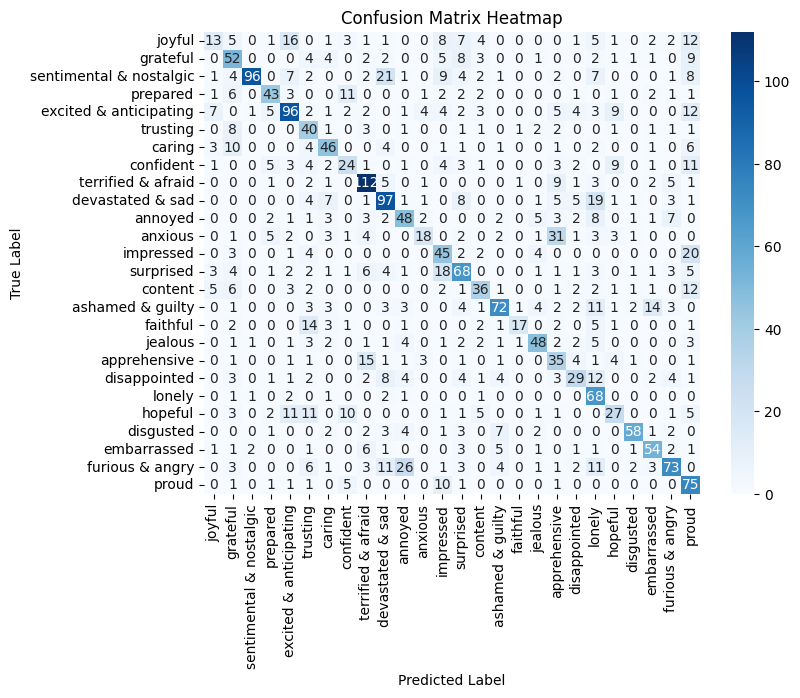

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels, yticklabels=emotion_labels)

# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()